In [1]:
from importlib import reload
import numpy as np
import torch
import matplotlib.pyplot as plt

import lab3.classes
reload(lab3.classes)
import lab3.classes as cs

import lab3.show
reload(lab3.show)
from lab3.show import show_image, mask_to_rgb_image

import lab3.trans
reload(lab3.trans)
from lab3.trans import validation_trans, train_trans, test_trans

import lab3.dataset
reload(lab3.dataset)
from lab3.dataset import FiftyOneDataset

import lab3.net
reload(lab3.net)
from lab3.net import Net

import lab1.device
reload(lab1.device)
from lab1.device import device

device

/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='mps')

In [2]:
from typing import Literal
import fiftyone as fo
import fiftyone.utils.openimages as fouo
import fiftyone.zoo as foz

def download(split = "train", max_samples: int = 1000): # TODO: 2000
  return foz.load_zoo_dataset(
    "open-images-v6",
    split        = split,
    label_types  = ["segmentations", "detections"],
    classes      = cs.classes_no_background,
    max_samples  = max_samples,
    dataset_dir  = "data-lab3",
    dataset_name =f"open-images-v6-{split}"
  )

def load(split = "train"):
  dataset =  fouo.OpenImagesV6DatasetImporter(
    dataset_dir = f"data-lab3/{split}",
    label_types = "segmentations"
  )

  dataset.setup()

  return dataset

# train_ds = download("train")
# valid_ds = download("validation", max_samples = 300)
# test_ds  = download("test", max_samples = 300)

train_ds = load("train")
valid_ds = load("validation")

train_ds #, fo.list_datasets()

In [3]:
def seconds_to_time(seconds):
    s = int(seconds) % 60
    m = int(seconds) // 60
    if m < 1:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h < 1:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

In [4]:
def evaluate(model, loader):
  print(f"Evaluating")
  model.eval()

  total_iou = 0.0
  total_dice = 0.0
  total_predictions = 0

  for images, true_masks in loader:
    images = images.to(device)
    true_masks = true_masks.numpy()

    with torch.no_grad():
      predictions = model(images)
    predictions = predictions.cpu().detach().numpy()

    true_masks = true_masks > 0.5
    predictions = predictions > 0.5

    intersection = np.sum(np.bitwise_and(true_masks, predictions))
    union = np.sum(np.bitwise_or(true_masks, predictions))

    # Jaccard = || A \intersect B || / || A \union B ||
    iou = intersection / union

    # DICE = 2 || A \intersect B || / (||A|| + ||B||)
    dice = 2 * intersection / (np.sum(true_masks) + np.sum(predictions))

    total_iou += iou
    total_dice += dice
    total_predictions += 1

  mean_iou  = total_iou / total_predictions
  mean_dice = total_dice / total_predictions
  return mean_iou, mean_dice

In [5]:
def train_epoch(optimizer, loss_func, model, loader):
  model.train()
  loss_acum = np.array([], dtype = np.float32)

  for images, mask in loader:
    images = images.to(device)
    mask = mask.to(device)

    pred = model(images)
    loss = loss_func(pred, mask)
    loss_acum = np.append(loss_acum, loss.cpu().detach().numpy())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return np.mean(loss_acum)

In [6]:
from datetime import datetime

def train_and_eval(model, loader_train, loader_valid, epoch_count = 10, learning_rate = 1e-3):
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  start_time = datetime.now()

  train_iou_acum  = []
  train_dice_acum = []
  valid_iou_acum  = []
  valid_dice_acum = []
  for epoch in range(epoch_count):
    print(f'Starting training')

    loss = train_epoch(optimizer, loss_func, model, loader_train)
    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'loss        | Elapsed: {elapsed}')

    train_iou, train_dice = evaluate(model, loader_train)

    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'eval train  | Elapsed: {elapsed}')

    current_time = datetime.now()
    
    valid_iou, valid_dice = evaluate(model, loader_valid)
    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'eval valid  | Elapsed: {elapsed}')

    train_iou_acum.append(train_iou)
    valid_iou_acum.append(valid_iou)
    train_dice_acum.append(train_dice)
    valid_dice_acum.append(valid_dice)
    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'valid_iou   | Elapsed: {elapsed}')

    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'Epoch: {epoch}, Time: {elapsed}, Training loss: {loss}')
    print(f'  Training IoU:  {train_iou.item():4f}, Validation IoU:  {valid_iou.item():4f}')
    print(f'  Training Dice: {train_dice.item():4f}, Validation Dice: {valid_dice.item():4f}')

  return train_iou_acum, valid_iou_acum, train_dice_acum, valid_dice_acum

In [7]:
def plot(train, valid, label = "IoU"):
  plt.clf()
  plt.plot(train, 'b', label = f'Training {label}')
  plt.plot(valid, 'r', label = f'Validation {label}')
  plt.ylim(0.0, 1.0)
  plt.legend()
  plt.show()

In [8]:
import torch

train_dataset = FiftyOneDataset(train_ds, train_trans)
valid_dataset = FiftyOneDataset(valid_ds, validation_trans)

num_workers = 8
batch_size = 512

train_ld = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
valid_ld = torch.utils.data.DataLoader(valid_dataset, batch_size = 1, num_workers = num_workers, shuffle = False)

print(f'Train: {len(train_dataset)}, Test: {len(valid_dataset)}')

Train: 808, Test: 157


In [9]:
model = Net(train_dataset[0][0].shape[0], num_classes = cs.num_classes).to(device)
print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

train_iou, valid_iou, train_dice, valid_dice = train_and_eval(model, train_ld, valid_ld, epoch_count = 3, learning_rate = 1e-3)
plot(train_iou, valid_iou)
plot(train_dice, valid_dice, label = "dice")

Parameter count: 441,318
Starting training
loss        | Elapsed: 1m0s
Evaluating
eval train  | Elapsed: 1m56s
Evaluating
eval valid  | Elapsed: 3m14s
valid_iou   | Elapsed: 3m14s
Epoch: 0, Time: 3m14s, Training loss: 0.00690842978656292
  Training IoU:  0.000000, Validation IoU:  0.000000
  Training Dice: 0.000000, Validation Dice: 0.000000
Starting training
loss        | Elapsed: 4m33s
Evaluating
eval train  | Elapsed: 5m35s
Evaluating
eval valid  | Elapsed: 6m50s
valid_iou   | Elapsed: 6m50s
Epoch: 1, Time: 6m50s, Training loss: 0.0068917591124773026
  Training IoU:  0.000000, Validation IoU:  0.000000
  Training Dice: 0.000000, Validation Dice: 0.000000
Starting training
loss        | Elapsed: 8m8s
Evaluating


In [ ]:
torch.save(model, 'lab3/model_attempt1.pth')

<Figure size 640x480 with 0 Axes>

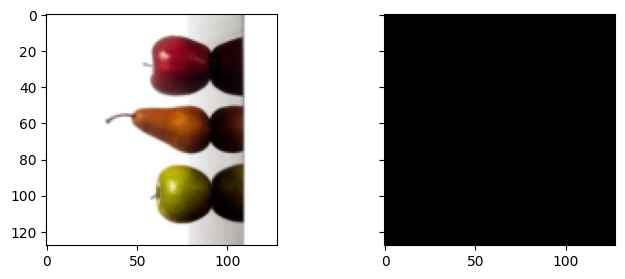

torch.Size([128, 128, 6])

In [ ]:
model = torch.load('lab3/model_attempt1.pth').to(device)

img, true_mask = valid_dataset[40]
true_masks = true_mask
# mask = model(img.unsqueeze(0).to(device)).cpu().detach().squeeze(0)

# aggregated_mask = lab3ds.aggregate_detections(mask)
show_image(img, mask_to_rgb_image(true_masks.permute(2, 1, 0), classes = cs.classes))
true_masks.permute(2, 1, 0).shape